## Paired datasets generation

This notebook refers to the generation of paired KD-Ctrl datasets (exons) to later perform in silico experiments with SpliceAI. We try to control for gene architecture feature such that the downstream analysis won't be confounded by this type of features. 

In [2]:
import pandas as pd 
import seaborn as sns
sns.set(font_scale=1)
from plotnine import *
from tqdm.notebook import tqdm
import scipy
import numpy as np
import seaborn as sns
import matplotlib.gridspec
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

pd.set_option("display.max_columns", None)
pd.set_option('display.width', 1000)
tqdm.pandas()

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


##### Load data - KD and Ctrl exons with gene architecture features 

In [154]:
KD_exons_wide = pd.read_csv('../data/1_KD_exons_dPSI0.1.tsv.gz', sep="\t")
KD_exons_wide.rename(columns={'group': 'rbp_name'}, inplace=True)
KD_exons_wide['exon_group'] = 'KD'
CTRL_exons_wide = pd.read_csv('../data/1_Ctrl_exons_dPSI0.025.tsv.gz', sep="\t")
CTRL_exons_wide.rename(columns={'group': 'rbp_name'}, inplace=True)
CTRL_exons_wide['exon_group'] = 'CTRL'

target_cols = ['target_coordinates', 'gene_name', 'gene_id', 'rbp_name', 'dPSI', 'exon_group']
KD_exons_long = KD_exons_wide[target_cols].copy()
KD_exons_long[['rbp_name', 'dPSI']] = KD_exons_long[['rbp_name', 'dPSI']].apply(lambda x: x.str.split(','))
KD_exons_long = KD_exons_long.explode(['rbp_name', 'dPSI'])
KD_exons_long['dPSI'] = KD_exons_long.dPSI.astype(float)

In [155]:
# Filter out exons with absent GCs in their features (e.g. very short introns/exons may not hold any G and C)
CTRL_exons_wide = CTRL_exons_wide[(CTRL_exons_wide.filter(
    items=['GC_target', 'GC_upstream_2', 'GC_downstream_2']) != 0).all(axis=1)]

In [156]:
merged = pd.concat([KD_exons_wide, CTRL_exons_wide]).reset_index(drop=True)
merged[['rbp_name', 'dPSI']] = merged[['rbp_name', 'dPSI']].apply(lambda x: x.str.split(','))
merged_exploded = merged.explode(['rbp_name', 'dPSI'])

Both KD and Ctrl exons show expected GC composition

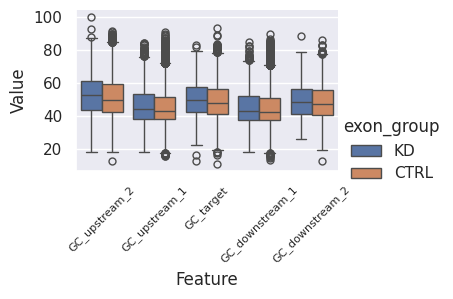

In [157]:
target_cols = ['target_coordinates', 'gene_id', 'exon_group'] + [c for c in merged.columns if "GC" in c]

aux = merged[target_cols].melt(id_vars=['target_coordinates', 'gene_id', 'exon_group'], var_name='Feature', value_name='Value')
aux['Feature'] = pd.Categorical(aux['Feature'], categories=['GC_upstream_2', 'GC_upstream_1', 'GC_target', 'GC_downstream_1', 'GC_downstream_2'])
g = sns.catplot(x="Feature",
            y="Value",
            data=aux, 
            hue="exon_group",
            kind="box", 
            height=2.5, 
            palette="deep",
            aspect=1.5)
g.set_xticklabels(rotation=45, fontsize=8)

In [158]:
def getClosestExon(exons: pd.DataFrame,
                   distance_based: bool = True,
                   distance_metric: str = "euclidean",
                   naive_agg_func: str = "max",
                   use_length: bool = False):
    """
    Extracts the closest control exon 
    for a given set of KD-responsive exons

    :param pd.DataFrame exons: Exons that did and did 
    not change their inclusions levels after a KD of a 
    single RBP

    :param bool distance_based: Whether to extract 
    the closest control exon using a measure of 
    distance between exons. Default: `True`

    :param str distance_metric: Distance metric to
    use when `distance_based` is `True`

    :param str naive_agg_func: Function to use to combine
    values of different features into a single score when
    `distance_based` is `False`. Default: `max`: The Max 
    feature difference between a KD-responsive and CTRL exons
    is used as "distance" between the two groups.

    :param bool use_length: Whether length of target exon
    and surrounding introns should be used as features
    """

    from scipy.spatial import distance
    from sklearn.preprocessing import RobustScaler, StandardScaler

    #########################
    ##### PREPROCESSING #####
    #########################
    # Generate new features. Instead of using Introns's GC content directly,
    # we use the difference in GC content to the cassette exon
    # exons['gc_diff_to_cass_ups'] = exons.GC_upstream - exons.GC_target
    # exons['gc_diff_to_cass_down'] = exons.GC_downstream - exons.GC_target

    # Features to use
    # attrib = ['GC_target', 'gc_diff_to_cass_ups', 'gc_diff_to_cass_down']
    attrib = ['GC_target', 'GC_upstream_1', 'GC_downstream_1']
    if use_length:
        _len_attrib = ['Length_target', 'Length_upstream_1', 'Length_downstream_1']
        attrib = attrib + _len_attrib

    _X = exons[attrib]

    # If length is used, scaling is performed
    # log10 of the lengths is performed before scaling
    # Scaling is necessary because the magnitude of the features is different
    # GC_ target is a %, GC_diff in introns is a difference of %, and length
    # is an integer variable that can go up to many thousands (e.g. long introns)
    if use_length:

        _X[_len_attrib] = np.log10(_X[_len_attrib])
        transformer = StandardScaler().fit(_X)
        X = transformer.transform(_X)

        exons_scaled = pd.merge(
            exons,
            pd.DataFrame(X,
                         index=exons.index,
                         columns=['scaled_{}'.format(x) for x in attrib]),
            left_index=True,
            right_index=True)

    # If len is not used, scaling is not performed
    else:
        exons_scaled = exons.copy()

    # Separate the two groups
    kd_exons = exons_scaled[exons_scaled.exon_group == "KD"]
    ctrls = exons_scaled[exons_scaled.exon_group == "CTRL"]

    out = []
    ###########################
    ##### Exon selection ######
    ###########################
    # For each KD exon, extract the closest CTRL exon
    for exon in kd_exons.itertuples():

        # Copy of original df
        _ctrls = ctrls.copy()

        
        # Select the scaled features that will actually be used to calculate distances
        if use_length:
            feature_cols = [x for x in _ctrls.columns if "scaled" in x]
        # No scaling
        else:
            feature_cols = attrib
        _exon = pd.Series({k: getattr(exon, k) for k in feature_cols})

        # Distance calculation
        if distance_based:

            # Compute distances using the provided metric
            dist = distance.cdist(_ctrls[feature_cols],
                                  np.array([_exon]),
                                  metric=distance_metric)

        else:
            # Compute distance using an aggregation function
            if use_length:
                diff_target = np.array(
                    (exon.scaled_GC_target -
                     _ctrls.scaled_GC_target).abs()).reshape(-1, 1)
                diff_upstream = np.array(
                    (exon.scaled_GC_upstream_1 -
                     _ctrls.scaled_GC_upstream_1).abs()).reshape(-1, 1)
                diff_downstream = np.array(
                    (exon.scaled_GC_downstream_1 -
                     _ctrls.scaled_GC_downstream_1).abs()).reshape(-1, 1)
                diff_len_ups = np.array(
                    (exon.scaled_Length_upstream_1 -
                     _ctrls.scaled_Length_upstream_1).abs()).reshape(-1, 1)
                diff_len_downs = np.array(
                    (exon.scaled_Length_downstream_1 -
                     _ctrls.scaled_Length_downstream_1).abs()).reshape(-1, 1)
                diff_len_target = np.array(
                    (exon.scaled_Length_target -
                     _ctrls.scaled_Length_target).abs()).reshape(-1, 1)
                _a = np.concatenate([
                    diff_target, diff_upstream, diff_downstream, diff_len_ups,
                    diff_len_downs, diff_len_target
                ],
                    axis=1)

            else:
                diff_target = np.array(
                    (exon.GC_target - _ctrls.GC_target).abs()).reshape(-1, 1)
                diff_upstream = np.array(
                    (exon.GC_upstream_1 - _ctrls.GC_upstream_1).abs()).reshape(
                        -1, 1)
                diff_downstream = np.array(
                    (exon.GC_downstream_1 - _ctrls.GC_downstream_1).abs()).reshape(
                        -1, 1)
                _a = np.concatenate(
                    [diff_target, diff_upstream, diff_downstream], axis=1)

            if naive_agg_func == "max":
                dist = np.max(_a, axis=1)
            elif naive_agg_func == "sum":
                dist = np.sum(_a, axis=1)
            elif naive_agg_func == "avg":
                dist = np.mean(_a, axis=1)

        # Select the ctrl exon with the lowest distance to our KD-exon
        # Account for dist 0 (same exon in two groups)
        #closest, _ = np.where(dist==np.min(dist[np.nonzero(dist)]))
        #selected_ctrl = _ctrls.iloc[closest[0]]
        selected_ctrl = _ctrls.iloc[np.argmin(dist)]

        # Calculte diff to selected ctrl
        # If len is used, the difference between the scaled values is extracted
        if use_length:
            diff_target = exon.scaled_GC_target - selected_ctrl.scaled_GC_target
            diff_upstream = exon.scaled_GC_upstream_1 - selected_ctrl.scaled_GC_upstream_1
            diff_downstream = exon.scaled_GC_downstream_1 - selected_ctrl.scaled_GC_downstream_1
            diff_len_ups = exon.scaled_Length_upstream_1 - \
                selected_ctrl.scaled_Length_upstream_1
            diff_len_target = exon.scaled_Length_target - selected_ctrl.scaled_Length_target
            diff_len_downs = exon.scaled_Length_downstream_1 - \
                selected_ctrl.scaled_Length_downstream_1
        else:
            diff_target = exon.GC_target - selected_ctrl.GC_target
            diff_upstream = exon.GC_upstream_1 - selected_ctrl.GC_upstream_1
            diff_downstream = exon.GC_downstream_1 - selected_ctrl.GC_downstream_1

        # Update overall output with the selected pair
        # KD_exon
        cols_to_keep = list(selected_ctrl.index)
        _exon = pd.Series({
            k: getattr(exon, k)
            for k in kd_exons.columns if k in cols_to_keep
        })

        if use_length:
            to_add = [
                selected_ctrl.target_coordinates,
                np.min(dist), diff_target, diff_upstream, diff_downstream,
                diff_len_ups, diff_len_target, diff_len_downs
            ]

        else:
            to_add = [
                selected_ctrl.target_coordinates,
                np.min(dist), diff_target, diff_upstream, diff_downstream
            ]
        out.append(_exon.to_list() + to_add)

        # CTRL exon
        out.append(list(selected_ctrl[cols_to_keep]) + [exon.target_coordinates])

        # Selection without replacement
        ctrls = ctrls[ctrls.target_coordinates != selected_ctrl.target_coordinates].copy()

    if use_length:
        new_cols = [
            'paired_with', 'distance_to_pair', 'GC_target_diff',
            'GC_upstream_diff', 'GC_downstream_diff', 'Length_upstream_diff',
            'Length_target_diff', 'Length_downstream_diff'
        ]
    else:
        new_cols = [
            'paired_with', 'distance_to_pair', 'GC_target_diff',
            'GC_upstream_diff', 'GC_downstream_diff'
        ]

    out = pd.DataFrame.from_records(out, columns=cols_to_keep + new_cols)
    return out

In [159]:
cols_to_subset = ['gene_name', 'transcript_id', 'transcript_type', 'target_coordinates', 'Strand', 'dPSI', 
                  'GC_target', 'Length_target', 'GC_upstream_1', 'Length_upstream_1', 'GC_downstream_1', 
                  'Length_downstream_1', 'rbp_name', 'exon_group']
int_cols = ['Length_target', 'Length_upstream_1', 'Length_downstream_1']
merged_exploded = merged_exploded[cols_to_subset].copy()
merged_exploded[int_cols] = merged_exploded[int_cols].astype(int)

In [160]:
%%capture
out = {}

for i, d in enumerate(['euclidean', 'cityblock', 'max'] +
                         ['euclidean', 'cityblock', 'max']):

    _d = d

    if i > 2:
        use_length = True
    else:
        use_length = False

    if i in [0, 1, 3, 4]:
        distance_based = True
    else:
        distance_based = False

    _out = merged_exploded.groupby('rbp_name').parallel_apply(
            getClosestExon,
            distance_based=distance_based,
            distance_metric=_d,
            naive_agg_func=_d,
            use_length=use_length).reset_index(drop=True)

    if use_length:
        name = d + "_l"
    else:
        name = d

    out[name] = _out

In [161]:
#################################
## Melt dataframe with feature ##
## differences between pairs ####
#################################
out_l = []
for name, _df in out.items():
    _df["analysis"] = name
    out_l.append(_df)

df = pd.concat(out_l, ignore_index=True)
os.makedirs("1_AllExonPairs", exist_ok=True)
df.to_csv("1_AllExonPairs/0_all_exon_pairs_extracted.tsv.gz", compression='gzip', sep="\t", index=False)

target_cols = [
    "target_coordinates",
    "rbp_name",
    "GC_target_diff",
    "GC_upstream_diff",
    "GC_downstream_diff",
    "analysis",
]

if "Length_target_diff" in df.columns:
    target_cols.extend(
        ["Length_target_diff", "Length_upstream_diff", "Length_downstream_diff"]
    )

diff_df = df[df.exon_group == "KD"][target_cols]
diff_melt_gc = diff_df.drop(columns=diff_df.filter(regex="Length_")).melt(
    id_vars=["target_coordinates", "rbp_name", "analysis"],
    var_name="Feature",
    value_name="Value",
)

diff_melt_len = (
    diff_df.drop(columns=diff_df.filter(regex="GC_"))
    .melt(
        id_vars=["target_coordinates", "rbp_name", "analysis"],
        var_name="Feature",
        value_name="Value",
    )
    .dropna()
)

diff_df_melt = pd.concat([diff_melt_gc, diff_melt_len])

In [162]:
#################################
## Count deviations from 1 std ##
#################################
# Calculate std per exon pair, rbp_name and feature
std_df = diff_df_melt.groupby(
    ['analysis', 'rbp_name',
     'Feature']).Value.agg('std').reset_index().rename(columns={'Value': 'std'})

_diff_df_melt = pd.merge(diff_df_melt,
                         std_df,
                         on=['analysis', 'rbp_name', 'Feature'])

# Is individual feature difference deviating from the std for that feature?
_diff_df_melt['dev_from_std'] = _diff_df_melt.Value.abs(
) > _diff_df_melt['std']

# Count number of deviations
_aux = _diff_df_melt.groupby(
    ['analysis', 'rbp_name', 'Feature',
     'std']).dev_from_std.apply(lambda x: x.value_counts()).reset_index()

# Rename, it's already in tidy
to_plot_std_dev = _aux.rename(columns={
    'dev_from_std': 'count',
    'level_4': 'dev_from_std'
})

In [163]:
##################################
## Plot N exon pairs deviating  ##
## 1 SD from the mean           ##
##################################
def plotExonPairsDeviatingFromSD(_df: pd.DataFrame):
    print(f"Processing {_df.name} feature differences")
    df = _df.copy()
    
    df['std'] = df['std'].apply(lambda x: round(x, 2)).astype(str)
    df['analysis_'] = df['analysis'] + " (std=" + df['std'] + ")"

    categories = [
        'euclidean_l', 'cityblock_l', 'max_l', 'euclidean',
        'cityblock', 'max']

    df['analysis'] = pd.Categorical(df.analysis,
                                    categories=categories,
                                    ordered=True)
    df.sort_values('analysis', inplace=True)
    sns.set(font_scale=5)
 
    g = sns.catplot(x="count",
                    y='analysis_',
                    col="rbp_name",
                    col_wrap=10,
                    data=df,
                    kind="bar",
                    hue="dev_from_std",
                    height=20,
                    aspect=0.8,
                    palette=['salmon', 'lightblue'],
                    sharex=False,
                    sharey=False)

    plt.savefig('plots/1_build_datasets_dist_diff_deviations_from_std_{}.pdf'.format(_df.name))

In [164]:
#%%catpure
#to_plot_std_dev.groupby('Feature').apply(plotExonPairsDeviatingFromSD)

In [165]:
#########################################
##### Plot Ctrl exon overlaps between ###
#####  different distance metrics #######
#########################################
from upsetplot import from_contents, plot   

sns.set(font_scale=1)
d_rename = {
    'euclidean': 'Euclidean',
    'cityblock': 'Manhathan',
    'max': 'max',
    'max_l': 'max_withlen',
    'cityblock_l': 'Manhathan_withlen',
    'euclidean_l': 'Euclidean_withlen'
}
def plotExonsOverlapBetweenMetrics(df: pd.DataFrame):
    
    name = df.name
    data = df[df.exon_group == "KD"][['analysis', 'paired_with']].groupby('analysis')['paired_with'].apply(list)

    data = data.rename(d_rename)
    if data.shape[0] > 50:
        plot(from_contents(data), show_counts=True, sort_by='cardinality', min_subset_size=10)
    else:
        plot(from_contents(data), show_counts=True, sort_by='cardinality')
    
    plt.savefig("plots/1_build_datasets_ctrl_overlap_between_dist_metrics_{}.pdf".format(name))

In [166]:
# %%capture
# df.groupby('rbp_name').apply(plotExonsOverlapBetweenMetrics)

Given the extracted exon pairs across different distance strategies, we now test whether the mean of differences between feature values (KD vs Exons) is different from zero. We count how many RBPs have significant differences from zero in any of the considered features (GC upstream, GC target, GC downstream). Hence, we want to find the distance metric that maximize the number of RBPs that don't reject the hypothesis that the mean difference in any feature is zero.

In [167]:
##################
### STATS PART ###
##################
from scipy.stats.mstats import ttest_1samp

def is_rbp_significant(rbp: pd.Series):
    """
    Assigns a label to whether there are significant 
    differences between the means of any of the features
    between the control and KD-responsive exons
    """
    cols = [c for c in rbp.index if "tstatistic" in c]
  
    if all(abs(rbp[x]) < rbp.critical_value for x in cols):
        rbp['is_significant'] = False
    else:
        rbp['is_significant'] = True
    return rbp


out = []
for analysis in diff_df.analysis.unique():
        
    # Subset data from individual analysis
    aux = diff_df.copy(deep=True)
    aux = aux[aux.analysis == analysis]
        
    # Calculate the critical points to reject null hypothesis that the mean of the sample is 0
    aux['critical_value'] = aux.groupby('rbp_name')['GC_target_diff'].transform(
            lambda x: scipy.stats.t.ppf(q=1 - .05 / 2, df=x.size - 1))
  
    crit_value_df = aux[['rbp_name', 'critical_value']].drop_duplicates().set_index('rbp_name').dropna()
  
    # Do the one sample t-tests, one per feature
    stats_df = aux.groupby('rbp_name')[['GC_target_diff', 'GC_upstream_diff', 'GC_downstream_diff']].agg(lambda x: ttest_1samp(x, 0))

    for c in stats_df.columns:
        stats_df[['{}_tstatistic'.format(c),
                '{}_pvalue'.format(c)]] = stats_df[c].tolist()
        stats_df.drop(columns=c, inplace=True)

    stats_df = stats_df.merge(crit_value_df, left_index=True,
                            right_index=True).apply(is_rbp_significant,
                                                    axis=1)

    stats_df['is_significant'] = stats_df.is_significant.astype(bool)
    stats_df['analysis'] = analysis
    out.append(stats_df.reset_index())

out_stats = pd.concat(out)
out_stats.set_index('rbp_name', inplace=True)

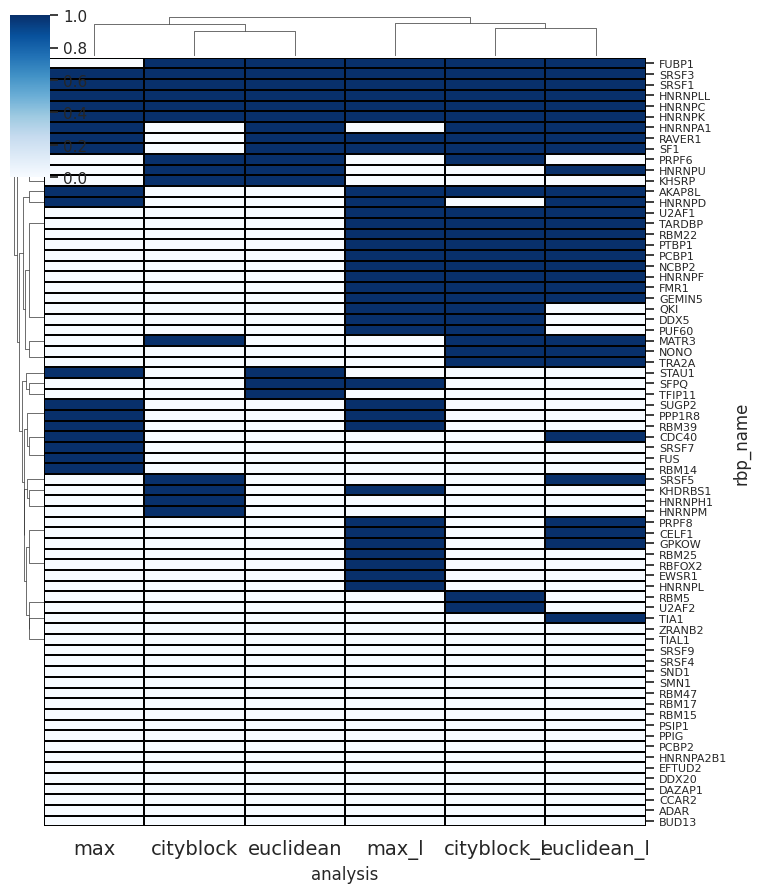

In [168]:
heat_data = pd.pivot_table(out_stats[['is_significant', 'analysis']],
                           values='is_significant',
                           index=out_stats.index,
                           columns='analysis')

heat_data = heat_data.fillna(-1)

#sns.heatmap(df1.iloc[:, 1:6:], annot=True, linewidths=.5, ax=ax)
g = sns.clustermap(
    data=heat_data,
    figsize=(8, 9),
    linecolor='black',
    linewidths=0.005,
    annot=False,
    dendrogram_ratio=.05,
    yticklabels=True,
    cmap='Blues')
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize=14)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize=8)
g.figure.savefig('plots/1_build_datasets_feature_diff_significance.pdf')

### Paired control extraction 

Our hypothesis is that KD-sensitive exons will have lower SpliceAI predictions than those control exons that show no differences after individual RBP knockdown, and that difference is not due to genome architecture features, but rather to other feature types (e.g, RBP motifs). Therefore, we extract the final controls pairs that harbor the worst accuracy when building a classifier to distinguish between exon groups, based on genome architecture features.

In [3]:
df = pd.read_csv("1_AllExonPairs/0_all_exon_pairs_extracted.tsv.gz", sep="\t")

In [4]:
# Merge predictions to feature's df
cols = ['target_coordinates', 'rbp_name', 'gene_name', 'transcript_id', 'GC_target',
        'Length_target', 'GC_upstream_1', 'Length_upstream_1', 'GC_downstream_1', 'Length_downstream_1',
        'exon_group', 'paired_with', 'dPSI', 'analysis']

data_to_ml = df[cols].copy()
data_to_ml.columns = [c.replace('_1', '') if c.endswith('_1') else c for c in data_to_ml.columns] 

# Transform length features to log10
length_cols = ['Length_target', 'Length_upstream', 'Length_downstream'] 
data_to_ml[length_cols] = np.log10(data_to_ml[length_cols])
#data_to_ml = data_to_ml.drop(columns=length_cols)

#### Decision tree to predict exon group

We create a classifier per RBP to predict exon group from genome architecture features. We should have very poor performance, because CTRls were specifically extracted to match KD-sensitive exons. It works as an additional validation stage of the dataset generation procedure.

In [5]:
from sklearn import tree
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics import accuracy_score

def dt_classifier(df: pd.DataFrame):
    """
    Simple classifier to distinguish exon group 
    based on genome architecture features
    """

    # Do classification for RBPs with at least 40 events
    if df.shape[0] < 80:
        return
    
    rbp = df.name[1]
        
    df = df.drop(columns=['analysis', 'rbp_name'])

    x = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    clf = tree.DecisionTreeClassifier(random_state=0, min_samples_leaf=3, max_depth=5)
    cv_results= cross_validate(clf, x, y, scoring='accuracy', cv=10, return_estimator=True)
    
    accuracies, feat_import = [],[]
    
    for i, model in enumerate(cv_results['estimator']):
        # tree.plot_tree(clf, feature_names=x.columns)
        feat_import.append(model.feature_importances_)
        accuracies.append(cv_results['test_score'][i])
        
    return rbp + "(N={})".format(df.shape[0] // 2), round(np.mean(accuracies), 3), np.array(feat_import).mean(axis=0).tolist()
 
    
X = data_to_ml[['GC_target', 'GC_upstream', 'GC_downstream',
                'Length_upstream', 'Length_target', 'Length_downstream',
                'rbp_name', 'analysis', 'exon_group']]

output_clf = X.groupby(['analysis', 'rbp_name']).apply(dt_classifier).reset_index().rename({0: 'out'}, axis=1)

output_clf = output_clf.dropna()
output_clf[['RBP_with_N', 'acc', 'feat_import']] = pd.DataFrame(output_clf.out.tolist(), index=output_clf.index)
output_clf.drop('out', axis=1, inplace=True)

/tmp/ipykernel_1571333/2057890401.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


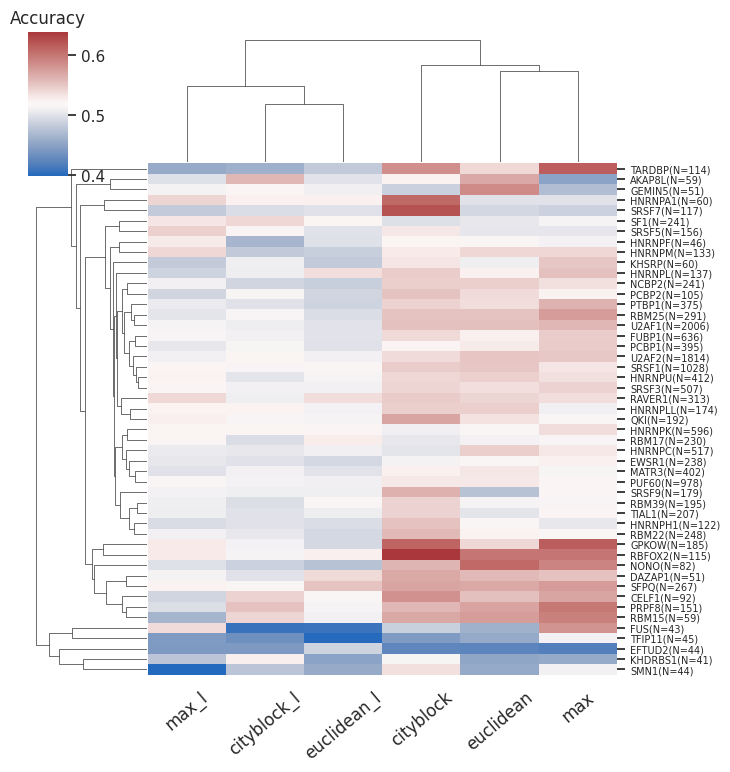

In [6]:
accuracies_heat = output_clf.pivot(index='RBP_with_N', columns='analysis', values='acc')
g = sns.clustermap(data=accuracies_heat, cmap="vlag", figsize=(8,8), yticklabels=True, dendrogram_ratio=0.2)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize=12)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize=7)
g.cax.set_title('Accuracy')
g.ax_heatmap.set_xlabel('')
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), rotation=40)
plt.savefig("plots/1_build_datasets_classification_accuracy.pdf")

In [7]:
medians = output_clf.groupby('analysis')['acc'].agg('median')
min_diff_idx = min(range(len(medians)), key=lambda i: abs(medians.iloc[i]-0.5))
metric = medians.index[min_diff_idx]
print(f'Median accuracies: {medians}')
print()
print(f'Distance metric selected: {metric} (median={medians.iloc[min_diff_idx]})')

Median accuracies: analysis
cityblock      0.543
cityblock_l    0.508
euclidean      0.534
euclidean_l    0.501
max            0.533
max_l          0.510
Name: acc, dtype: float64

Distance metric selected: euclidean_l (median=0.501)


#### Write final paired datasets to disk

In [9]:
final = df[df.analysis == "euclidean_l"]

In [82]:
DATASETS_DIR = '../data/2_paired_datasets'
os.makedirs(DATASETS_DIR, exist_ok=True)
    
def longToWide(df: pd.DataFrame):
    """
    Writes a dataset per RBP with respective pairs in the same row
    """
    rbp = df.name
    kd = df[df.exon_group == "KD"].drop(
        columns=['exon_group', 'paired_with'])
    ctrl = df[df.exon_group == "CTRL"].drop(columns=['rbp_name', 'exon_group'])

    merged = pd.merge(kd, ctrl, left_on='target_coordinates', right_on='paired_with', suffixes=[
                      '_KD', '_CTRL']).drop(columns=['paired_with'])
    merged.rename(columns={'target_coordinates_KD': 'exon_KD',
                           'target_coordinates_CTRL': 'exon_CTRL',
                           'rbp_name': 'RBP'}, inplace=True)

    sort_cols = ['exon_KD', 'Strand_KD', 'gene_name_KD', 'transcript_id_KD', 'dPSI_KD',
                 'exon_CTRL', 'Strand_CTRL', 'gene_name_CTRL', 'transcript_id_CTRL', 'dPSI_CTRL', 'RBP']
    merged[sort_cols].to_csv(f"{DATASETS_DIR}/{rbp}_data.tsv", sep="\t", index=False)  
    return merged[sort_cols]

In [12]:
cols = ['target_coordinates',
        'Strand',
        'gene_name',
        'transcript_id',
        'rbp_name',
        'exon_group',
        'dPSI',
        'paired_with']

final[cols].to_csv(f"{DATASETS_DIR}/ALL_data.tsv.gz", sep="\t", index=False, compression='gzip')
final_wide = final[cols].groupby('rbp_name').apply(longToWide).reset_index(level=0).reset_index(drop=True)

In [196]:
# Write per-exon group exon occurences across multiple RBPs
exon_counts = final[cols].groupby('target_coordinates')['exon_group'].value_counts().to_frame('counts').reset_index()
exon_counts = exon_counts.pivot(index='target_coordinates', columns='exon_group').fillna(0)
exon_counts = exon_counts.droplevel(0, axis=1).reset_index()
exon_counts.columns.name = None

int_cols = ['CTRL', 'KD']
exon_counts[int_cols] = exon_counts[int_cols].astype(int)
exon_counts.to_csv(f"{DATASETS_DIR}/ALL_EXON_COUNTS.tsv.gz", sep="\t", compression='gzip', index=False)

#### Plot feature distribution for the best distance configuration

In [18]:
less_than_40 = ['RBM14', 'CDC40', 'SUGP2', 'TIA1', 'RBM5', 'DDX5', 'PPP1R8', 'HNRNPD',
       'HNRNPA2B1', 'ADAR', 'PRPF6', 'STAU1', 'RBM47', 'PPIG', 'TRA2A',
       'PSIP1', 'FMR1', 'ZRANB2', 'SND1', 'BUD13', 'CCAR2', 'SRSF4', 'DDX20']

In [19]:
n_before = final.shape[0]
final = final[~final.rbp_name.isin(less_than_40)]
print(f"Removed {n_before - final.shape[0]} sequences from datasets of KD experiments with less than 40 events detected.")

Removed 882 sequences from datasets of KD experiments with less than 40 events detected.


In [97]:
#################################
##### Plot distribution of ######
#####    feature values    ######
#################################
def plotFeaturesDistribution(df: pd.DataFrame):
    """
    Plot distributions of each feature in 
    KD-responsive and CTRL exons
    """
    name = df.name

    group_sizes = df.groupby('rbp_name').size().sort_values(ascending=False)
    df['rbp_name_with_size'] = pd.Categorical(df['rbp_name'], categories=group_sizes.index, ordered=True)
    df['rbp_name_with_size'] = df['rbp_name_with_size'].apply(lambda x: f"{x} (N={group_sizes[x]})")

    df.rename(columns={'Length_upstream_1': 'Log10(Length_intron_upstream)',
                       'Length_downstream_1': 'Log10(Length_intron_downstream)',
                       'Length_target': 'Log10(Length_cassette_exon)',
                       'GC_upstream_1': 'GC_intron_upstream',
                       'GC_downstream_1': 'GC_intron_downstream',
                       'GC_target': 'GC_cassette_exon'}, inplace=True)

    for x in ['Log10(Length_intron_upstream)', 'Log10(Length_intron_downstream)', 'Log10(Length_cassette_exon)', 
              'GC_intron_upstream', 'GC_cassette_exon', 'GC_intron_downstream']:
    #for x in ['GC_cassette_exon']:
        if 'Length' in x:
            df[x] = np.log10(df[x])
            bw = 0.1
        else:
            bw = 1.5
    
        p1 = (ggplot(df, aes(x=x, fill='exon_group')) +
            geom_density(alpha=0.7, bw=bw) + facet_wrap('rbp_name_with_size', scales='free', ncol=5) +
            theme(figure_size=(11, 12),
                axis_title=element_text(size=20),
                axis_text_x=element_text(size=10),
                axis_text_y=element_text(size=10),
                strip_text=element_text(size=10),
                legend_text=element_text(size=15)))

        p1.save('plots/1_build_datasets_feature_distr_{}_{}.pdf'.format(name, x))

In [98]:
# %%capture
final.groupby('analysis').apply(plotFeaturesDistribution)

/home/pbarbosa/miniconda3/envs/mutsplice/lib/python3.10/site-packages/plotnine/ggplot.py:604: PlotnineWarning: Saving 11 x 12 in image.
/home/pbarbosa/miniconda3/envs/mutsplice/lib/python3.10/site-packages/plotnine/ggplot.py:605: PlotnineWarning: Filename: plots/1_build_datasets_feature_distr_euclidean_l_Log10(Length_intron_upstream).pdf


/home/pbarbosa/miniconda3/envs/mutsplice/lib/python3.10/site-packages/plotnine/ggplot.py:604: PlotnineWarning: Saving 11 x 12 in image.
/home/pbarbosa/miniconda3/envs/mutsplice/lib/python3.10/site-packages/plotnine/ggplot.py:605: PlotnineWarning: Filename: plots/1_build_datasets_feature_distr_euclidean_l_Log10(Length_intron_downstream).pdf
/home/pbarbosa/miniconda3/envs/mutsplice/lib/python3.10/site-packages/plotnine/ggplot.py:604: PlotnineWarning: Saving 11 x 12 in image.
/home/pbarbosa/miniconda3/envs/mutsplice/lib/python3.10/site-packages/plotnine/ggplot.py:605: PlotnineWarning: Filename: plots/1_build_datasets_feature_distr_euclidean_l_Log10(Length_cassette_exon).pdf
/home/pbarbosa/miniconda3/envs/mutsplice/lib/python3.10/site-packages/plotnine/ggplot.py:604: PlotnineWarning: Saving 11 x 12 in image.
/home/pbarbosa/miniconda3/envs/mutsplice/lib/python3.10/site-packages/plotnine/ggplot.py:605: PlotnineWarning: Filename: plots/1_build_datasets_feature_distr_euclidean_l_GC_intron_upst

""


#### Get SpliceAI predictions for all exons

In [190]:
os.makedirs("1_SpliceAI", exist_ok=True)
target_cols = ['target_coordinates', 'gene_name', 'transcript_id', 'Strand']
exons_to_run_spliceai = final[target_cols].drop_duplicates()
exons_to_run_spliceai.to_csv("1_SpliceAI/0_to_run_SpliceAI.tsv", sep="\t", index=False)

Get SpliceAI predictions of all exons

In [ ]:
from gtfhandle.utils import file_to_bed_df
from explainer.datasets.preprocessing import Preprocessing
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


GTF_CACHE = "/home/pbarbosa/data/genomes/hg38/gtf_cache_gencode/"
OUT_DIR = "/home/pbarbosa/git_repos/mutsplice/notebooks/1_spliceai/"
FASTA = "/home/pbarbosa/data/genomes/hg38/GRCh38.primary_assembly.genome.fa"
kwargs = {
    "gtf_cache": GTF_CACHE,
    "out_dir": OUT_DIR,
    "outbasename": "encode",
    "fasta": FASTA,
    "spliceai_save_raw": True,
    "spliceai_raw_results": None,
    "batch_size": 64,
    "use_full_sequence":False,
}
bed_df = file_to_bed_df('1_SpliceAI/0_to_run_SpliceAI.tsv', is_0_based=False, header=0, col_index=0)
#bed_df = file_to_bed_df(exons_to_run_spliceai, is_0_based=False, header=0, col_index=0)

# preprocess = Preprocessing(bed_df,
#                         do_gtf_queries=True,
#                         do_motif_scanning=False,
#                         do_mutations=False,
#                         run_spliceai=True,
#                         **kwargs)

We load the predictions and create datasets for downstream analysis 

In [137]:
df = pd.read_csv('../data/2_paired_datasets/ALL_data.tsv.gz', sep="\t")
preds = pd.read_csv("1_SpliceAI/4_datasets/encode_sequences_fixed_at_5000bp_output.tsv.gz", sep="\t")

preds['pred'] = preds[['ref_donor_cassette', 'ref_acceptor_cassette']].mean(axis=1)
preds = preds[['seq_id', 'target_coordinates', 'pred']]
preds['transcript_id'] = preds.seq_id.str.split("_").str[1]

#### Plot predictions per group

In [138]:
df = df[~df.rbp_name.isin(less_than_40)]
group_sizes = df.groupby('rbp_name').size().sort_values(ascending=False)
df['rbp_name'] = pd.Categorical(df['rbp_name'], categories=group_sizes.index, ordered=True)
#df['rbp_name_with_size'] = df['rbp_name_with_size'].apply(lambda x: f"{x} (N={group_sizes[x]})")

In [139]:
# Join predictions to paired datasets and do t.tests
to_drop = ['seq_id', 'transcript_id', 'gene_name', 'Strand']
merge_on = ['target_coordinates', 'transcript_id']
df =  pd.merge(df, preds,
            left_on=merge_on,
            right_on=merge_on).drop(to_drop, axis=1)
            

In [140]:
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests

ttest = (
    df.groupby("rbp_name")
    .apply(
        lambda x: ttest_rel(
            x[x.exon_group == "KD"].pred, x[x.exon_group == "CTRL"].pred
        )
    )
    .reset_index()
)
ttest.rename(columns={0: "out"}, inplace=True)
ttest[["t_statistic", "p_val"]] = ttest.out.tolist()
_, pvals, _, _ = multipletests(
    ttest.p_val,
    alpha=0.05,
    method="holm",
    maxiter=1,
    is_sorted=False,
    returnsorted=False,
)
ttest["p_val_corrected"] = pvals
ttest.drop("out", axis=1, inplace=True)

counts = df.groupby('rbp_name').apply(lambda x: x[x.exon_group == "KD"].shape[0])
counts.name = 'N_exons'
ttest_df = pd.merge(ttest, counts, left_on='rbp_name', right_index=True)
ttest_df['rbp_name_with_N'] = ttest_df.apply(lambda x: x.rbp_name + f" (N={x.N_exons})", axis=1)
ttest_df = ttest_df.sort_values('N_exons', ascending=False)

/tmp/ipykernel_1571333/979896893.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/tmp/ipykernel_1571333/979896893.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/tmp/ipykernel_1571333/979896893.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/tmp/ipykernel_1571333/979896893.py:26: DeprecationWarning: DataFrameGr

In [141]:
# Draw heatmaps of significance
from matplotlib.colors import LinearSegmentedColormap
def plot_significance_between_spliceai_preds(df: pd.DataFrame):
	sns.set(font_scale=1)
	# Plot overall paired t tests results
	df['Is significant'] = df.p_val_corrected < 0.05
	df = df.set_index('rbp_name_with_N')
	c = [c for c in df.columns if 'Is significant' in c]

	# Set up the matplotlib figure
	f, ax = plt.subplots(figsize=(1.8,6))

	colors = ["lightgray", "maroon"] 
	cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))

	# Draw the heatmap with the mask and correct aspect ratio
	g = sns.heatmap(df[c], 
					yticklabels=True,
					cmap=cmap,
					square=True,
					linecolor='black',
					linewidths=0.05, 
					cbar_kws={"shrink": .2, 'location': 'right', 'pad':0.3})

	g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 6)
	g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 9)
	g.set_ylabel('')
	# Set the colorbar labels
	colorbar = ax.collections[0].colorbar
	colorbar.set_ticks([0.25,0.75])
	colorbar.set_ticklabels(['False', 'True'])
	colorbar = plt.gcf().axes[-1]
	colorbar.set_title('p <= 0.05', loc='left')

	plt.tight_layout()
	plt.savefig('plots/2_paired_datasets_preds_per_exon_group_significance.pdf')

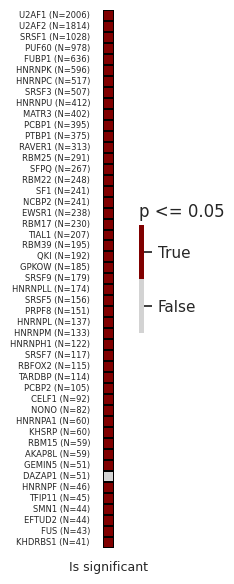

In [142]:
plot_significance_between_spliceai_preds(ttest_df)

In [154]:
def plotPredsPerGroup(df: pd.DataFrame):

    # for rbp, _df in df.groupby("rbp_name"):
    #     fig, ax = plt.subplots(figsize=(5, 4))
    #     ax = sns.catplot(
    #         x="exon_group",
    #         y="SpliceAI score",
    #         kind="box",
    #         data=_df,
    #         hue="exon_group",
    #         legend=False,
    #         palette=["burlywood", "gray"]
    #     )

    #     ax.map_dataframe(
    #         sns.stripplot, x="exon_group", y="SpliceAI score", alpha=0.2, color=".4"
    #     )

    #     # Add pvalues as annotations
    #     _ttest_df = ttest_df[ttest_df.rbp_name == rbp].squeeze()
    #     x1, x2 = 0, 1
    #     y, h, col = 1.05, 0.01, "k"
    #     plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)

    #     pval = format(_ttest_df.p_val_corrected, ".3g")
    #     plt.text(
    #         (x1 + x2) * 0.5,
    #         y + 0.025,
    #         "ns" if float(pval) > 0.05 else "p={}".format(pval),
    #         ha="center",
    #         va="bottom",
    #         color=col,
    #     )

    #     ax.fig.suptitle("{}".format(_ttest_df.rbp_name_with_N))
    #     plt.xlabel("")
    #     plt.tight_layout()
    #     plt.savefig(f"plots/2_paired_datasets_preds_per_exon_group_{rbp}.pdf")
    #     plt.close()
    #     matplotlib.pyplot.close()

    sns.set(font_scale=5)
    g = sns.catplot(
        x="exon_group",
        y="SpliceAI score",
        col="rbp_name_with_N",
        col_wrap=5,
        kind="box",
        data=df,
        palette=["burlywood", "gray"],
        hue="exon_group",
        legend=False,
        height=10,
        aspect=1,
    )
    # g.map_dataframe(
    #     sns.stripplot, x="exon_group", y="SpliceAI score", color=".4", alpha=0.2
    # )
   
    plt.subplots_adjust(top=0.75)
    g.set_axis_labels("", visible=False)
    for ax in g.axes.flat:
        ax.set_title(ax.get_title().replace('rbp_name_with_N = ', ''))

    g.fig.savefig(f"plots/2_paired_datasets_preds_per_exon_group_all.pdf")
    sns.set(font_scale=1)

In [146]:
df.rename(columns={'pred': 'SpliceAI score'}, inplace=True)
df['exon_group'] = df.exon_group.map({'CTRL': 'Control', 'KD': 'Knockdown'})
df = pd.merge(df, ttest_df[['rbp_name', 'rbp_name_with_N', 'N_exons']])
df = df.sort_values('rbp_name')
_df = df.copy()

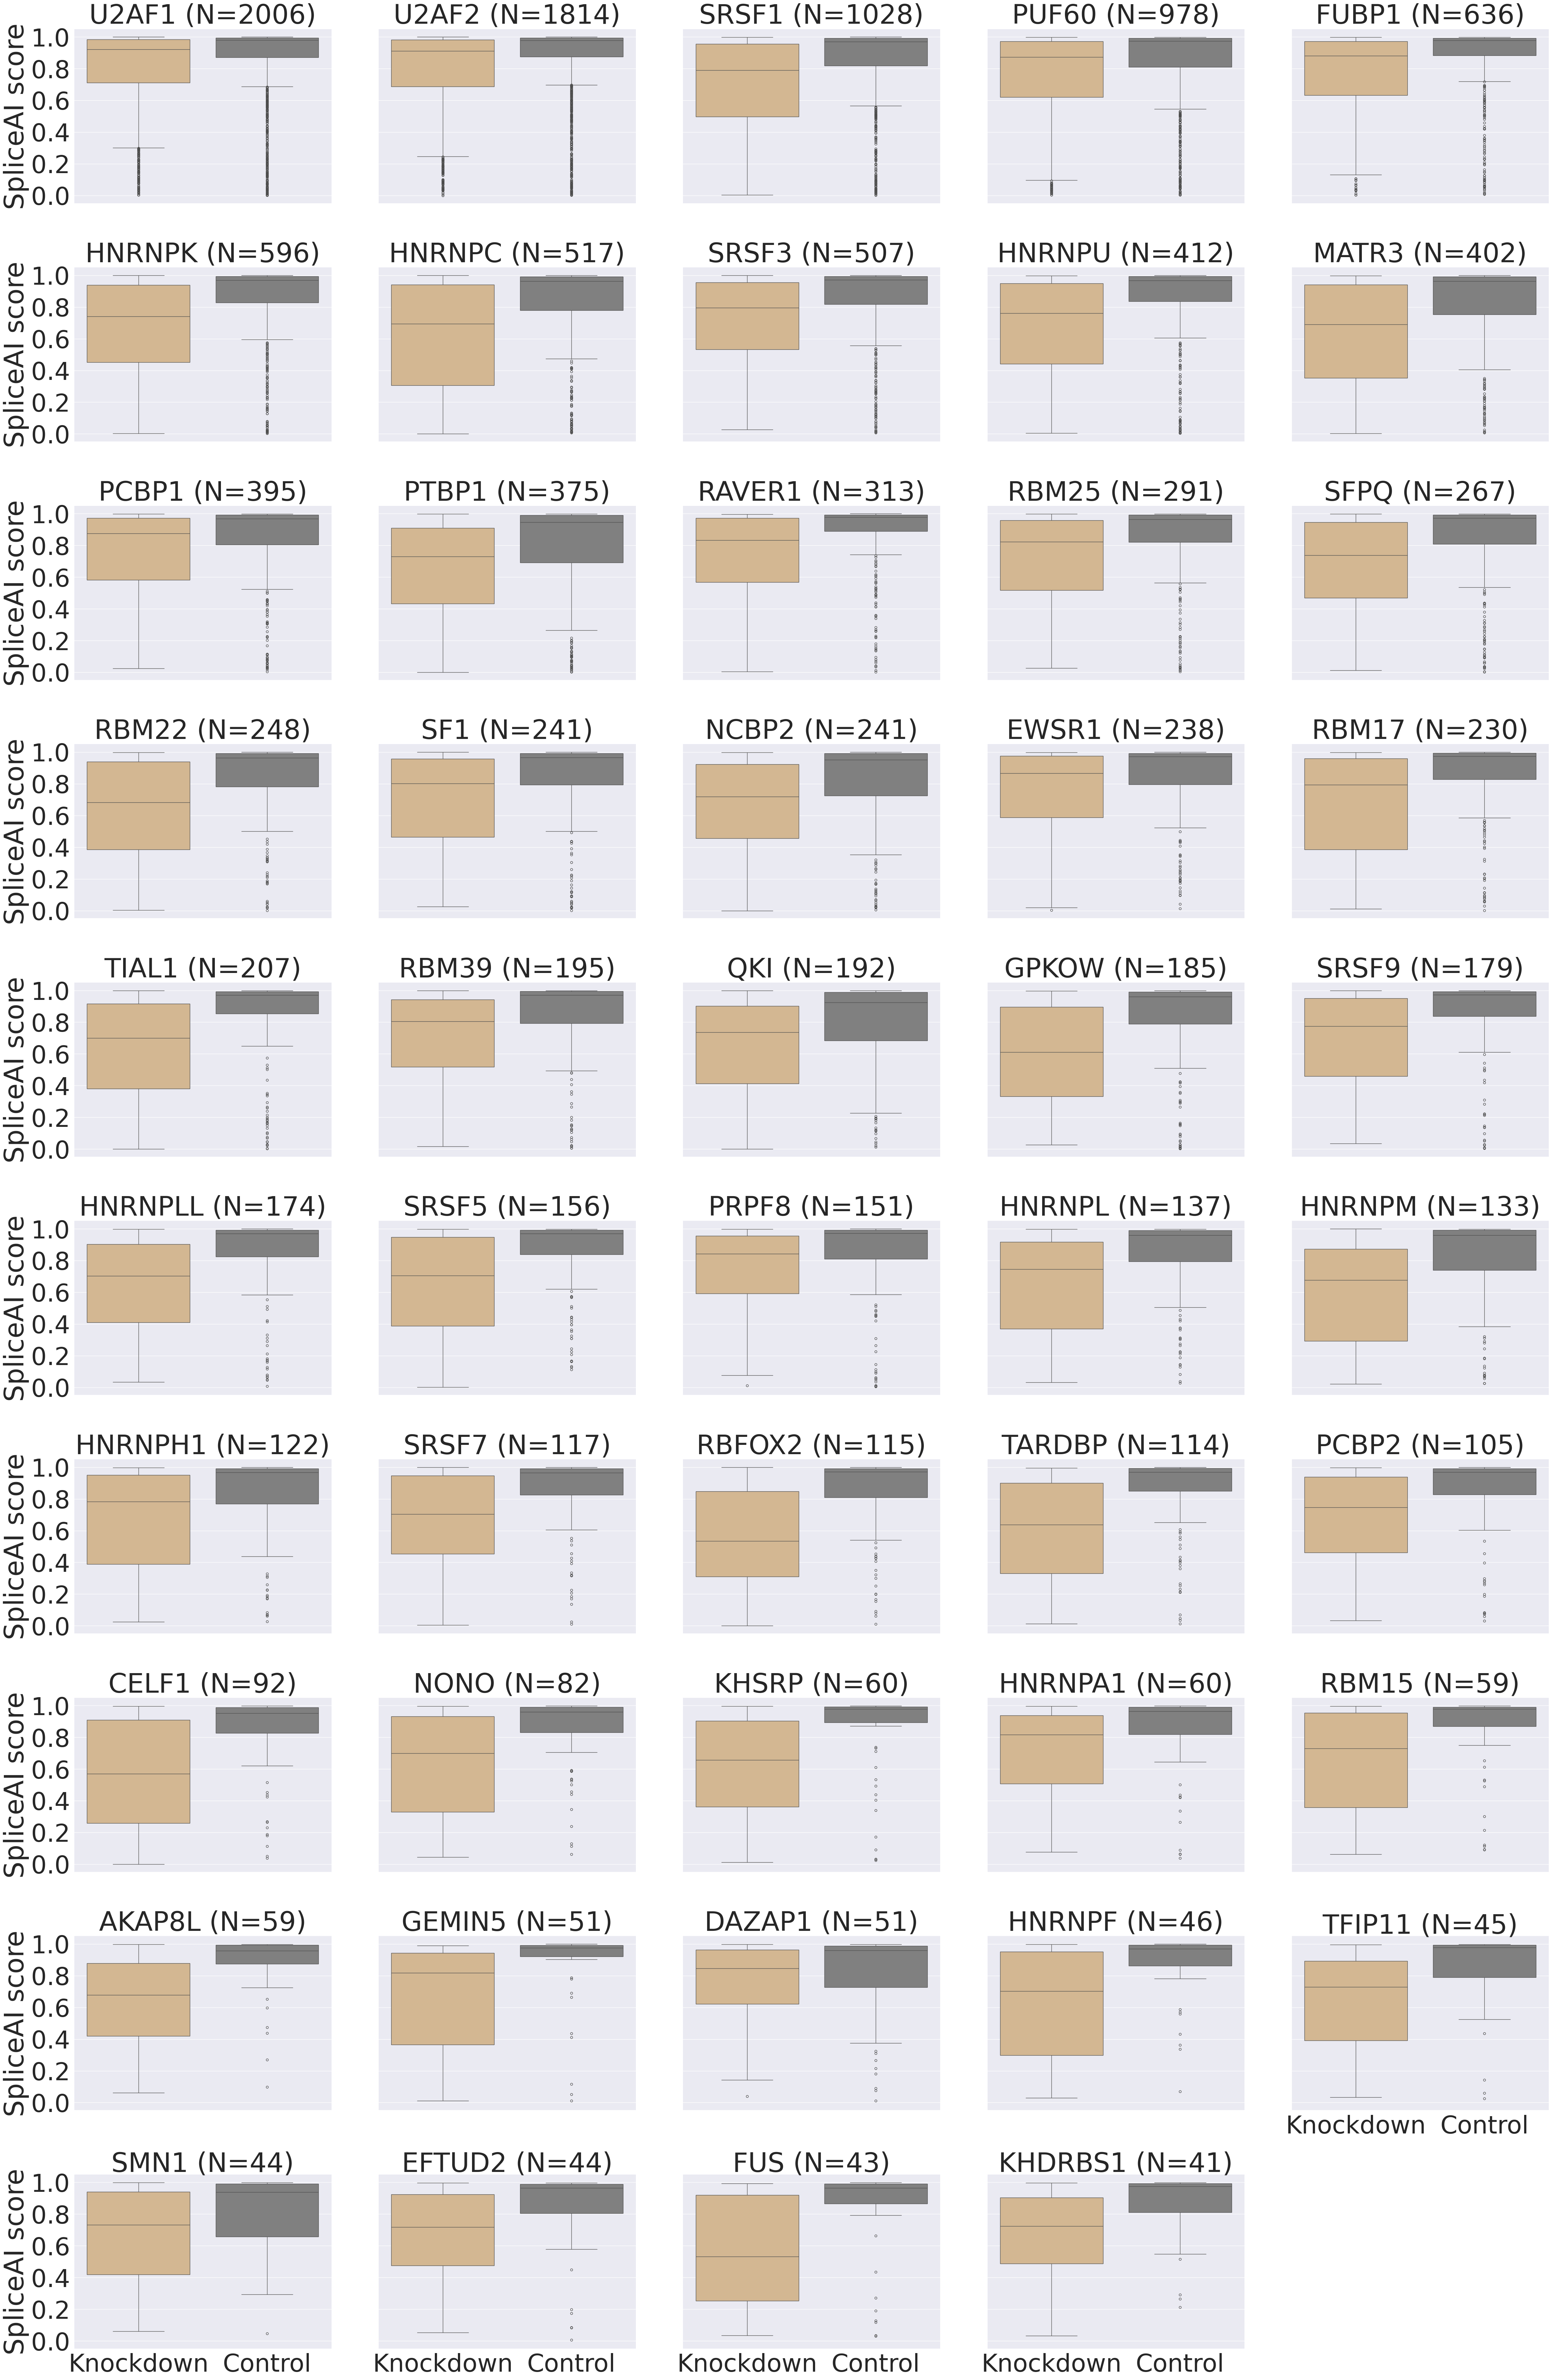

In [155]:
plotPredsPerGroup(_df)

Get distribution of differences between Ctrl and KD SpliceAI predictions

In [149]:
def _get_preds_diff(rbp_df):
    kd = rbp_df[rbp_df.exon_group == "Knockdown"]
    ctrl = rbp_df[rbp_df.exon_group == "Control"]
    out = []
    for _, kd_exon in kd.iterrows():
        ctrl_pair = ctrl[ctrl.target_coordinates == kd_exon.paired_with]
        assert ctrl_pair.shape[0] == 1
        out.append(ctrl_pair.squeeze()['SpliceAI score'] - kd_exon['SpliceAI score'])
    return out
pred_diffs = _df.groupby('rbp_name_with_N').apply(_get_preds_diff, include_groups=False)

In [150]:
pred_diffs = pred_diffs.reset_index()
pred_diffs.columns = ['rbp_name', 'values']
pred_diffs = pred_diffs.explode('values')

In [151]:
pred_diffs = pred_diffs.merge(
    ttest_df[["rbp_name_with_N", "N_exons"]],
    left_on="rbp_name",
    right_on="rbp_name_with_N",
).sort_values("N_exons", ascending=False).drop(columns=["rbp_name_with_N", "N_exons"])

In [152]:
def plotDistributionOfSpliceAIDifferences(df: pd.DataFrame):
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    g = sns.FacetGrid(df, col="rbp_name", col_wrap=3, hue='rbp_name', aspect=6, height=0.5)
    g.map(sns.kdeplot, "values", fill=True, alpha=0.7, color='skyblue', bw_adjust=1, linewidth=1, zorder=0)
    g.map(sns.kdeplot, "values", color='black', bw_adjust=1, linewidth=0.7, zorder=0)
    g.fig.subplots_adjust(hspace=-.75)

    for ax in g.axes.flat:
        ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
        ax.text(-0.1, 0.1, '='.join(ax.get_title().split("=")[1:]), transform=ax.transAxes,
                fontsize=7, fontweight='bold', va='center', ha='left')

        median_value = np.median(df[df['rbp_name'] == ax.get_title().replace("rbp_name = ", "")]['values'])
        ax.axvline(x=median_value, color='darkred', linestyle='--', linewidth=1, ymin=0.025, ymax=0.25, zorder=1)
        
    g.set_titles("")
    g.set(yticks=[])
    g.set_ylabels('')
    g.fig.text(0.5, 0.05, "SpliceAI score difference (Ctrl - Knockdown)", ha="center", va="bottom")
    plt.subplots_adjust(top=0.75)
    
    g.set_axis_labels("SpliceAI score difference (Ctrl - Knockdown)", visible=False)
    g.despine(left=True)
    g.fig.savefig("plots/2_paired_datasets_preds_diffs.pdf")

/home/pbarbosa/miniconda3/envs/mutsplice/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
/home/pbarbosa/miniconda3/envs/mutsplice/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
/home/pbarbosa/miniconda3/envs/mutsplice/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.


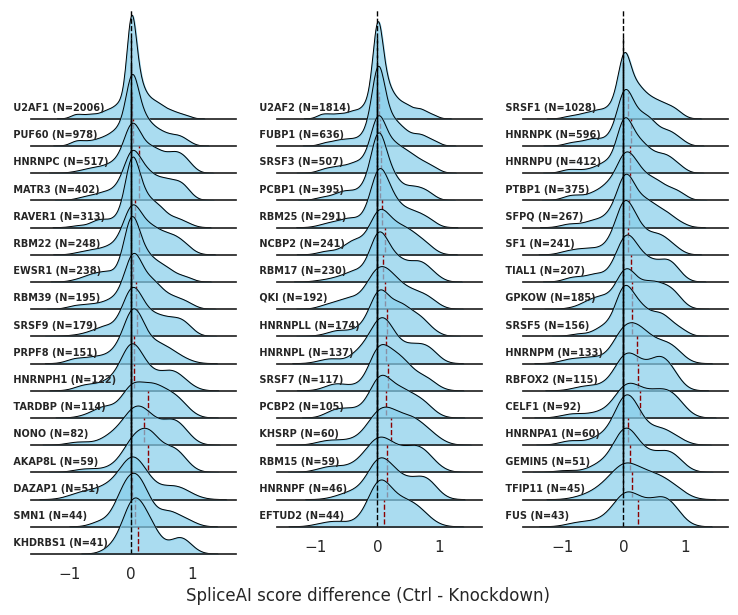

In [153]:
plotDistributionOfSpliceAIDifferences(pred_diffs)